In [83]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm

In [84]:
data = pd.read_csv(r'C:\Users\theom\Desktop\INFRATAL\MonteCarlo TAL\Database\df_currency_10y.csv', parse_dates=True)
data.set_index('date', inplace=True)


In [85]:
data['TALUSD'] = (1/data['USDCHF'])*100 + (1/data['USDEUR'])*250 + (1/data['USDGBP'])*50 + (1/data['USDJPY'])*18000 + (1/data['USDCNY'])*1600 + (1/data['USDSGD']*80) + ((data['USDGOLD'])*0.2)

data['TALUSD'] = data['TALUSD']*0.001

<AxesSubplot:xlabel='date'>

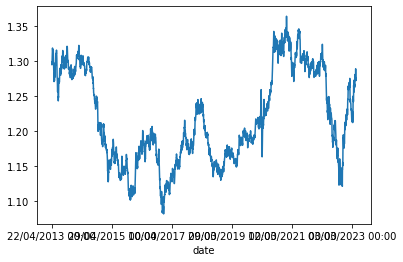

In [86]:
data['TALUSD'].plot()

In [87]:
weights_m = np.array([(1/data['USDCHF'])*100,(1/data['USDEUR'])*250,(1/data['USDGBP'])*50,(1/data['USDJPY'])*18000,(1/data['USDCNY'])*1600,(1/data['USDSGD'])*80,((data['USDGOLD'])*0.2)])
for i in range(len(weights_m)):
    weights_m[i] = weights_m[i]/data['TALUSD']
    weights_m[i] = weights_m[i]/1000
weights_mean = np.array([weights_m[0].mean(),weights_m[1].mean(),weights_m[2].mean(),weights_m[3].mean(),weights_m[4].mean(),weights_m[5].mean(),weights_m[6].mean()])

In [92]:
weights_last = np.array([weights_m[0][len(weights_m[0])-1],weights_m[1][len(weights_m[1])-1],weights_m[2][len(weights_m[2])-1],weights_m[3][len(weights_m[3])-1],weights_m[4][len(weights_m[4])-1],weights_m[5][len(weights_m[5])-1],weights_m[6][len(weights_m[6])-1]])

In [93]:
data.drop('TALUSD', axis=1, inplace=True)

In [94]:
corr = data.corr()
corr

,USDSGD,USDCNY,USDEUR,USDGBP,USDCHF,USDJPY,USDGOLD
USDSGD,1.000000,0.705965,0.871214,0.699631,0.644611,0.484217,0.063986
USDCNY,0.705965,1.000000,0.689613,0.887255,0.502233,0.298506,0.276754
USDEUR,0.871214,0.689613,1.000000,0.763571,0.598007,0.723288,0.188186
USDGBP,0.699631,0.887255,0.763571,1.000000,0.459008,0.430903,0.437526
USDCHF,0.644611,0.502233,0.598007,0.459008,1.000000,0.244897,-0.456669
USDJPY,0.484217,0.298506,0.723288,0.430903,0.244897,1.000000,0.218447
USDGOLD,0.063986,0.276754,0.188186,0.437526,-0.456669,0.218447,1.000000


([<matplotlib.axis.YTick at 0x234e32b9d60>,
 [Text(0, 0, 'USDSGD'),
  Text(0, 1, 'USDCNY'),
  Text(0, 2, 'USDEUR'),
  Text(0, 3, 'USDGBP'),
  Text(0, 4, 'USDCHF'),
  Text(0, 5, 'USDJPY'),
  Text(0, 6, 'USDGOLD')])

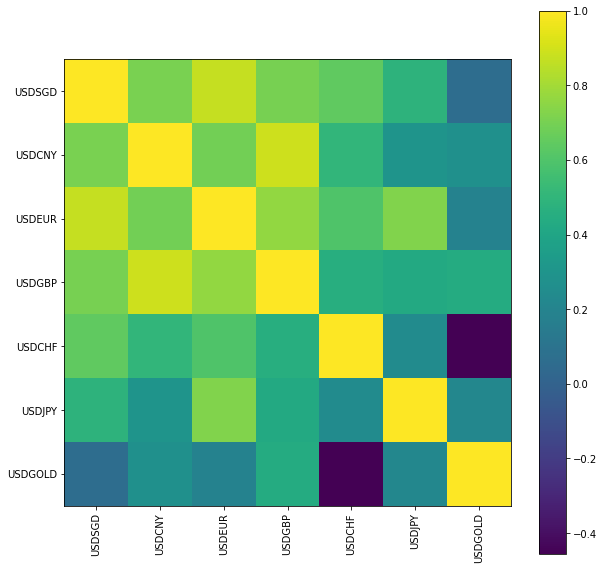

In [95]:
plt.figure(figsize=(10, 10))
plt.imshow(corr, interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)



In [96]:
returns = data.pct_change()
vol = returns.std() * np.sqrt(252)
returns = returns.mean()

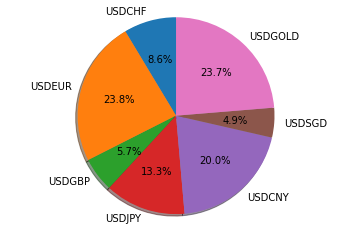

In [97]:
labels = ['USDCHF','USDEUR','USDGBP','USDJPY','USDCNY','USDSGD','USDGOLD']
sizes = weights_mean    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)    
ax1.axis('equal')
plt.show()


In [98]:
# Define the number of simulations and the time horizon
n_simulations = 1000
time_horizon = 10

# Generate random samples from a multivariate normal distribution
samples = np.random.multivariate_normal(returns, np.outer(vol, vol) * corr, size=n_simulations)

# Calculate the ETF returns for each simulation
x = data.tail(1).values
prices = x * np.cumprod(1 + samples, axis=1)
# Compute TALUSD for each simulation
prices = pd.DataFrame(prices)
prices.columns =  ['USDSGD','USDCNY','USDEUR','USDGBP','USDCHF','USDJPY','GOLDUSD']

In [99]:
prices['TALUSD'] = (1/prices['USDCHF'])*100 + (1/prices['USDEUR'])*250 + (1/prices['USDGBP'])*50 + (1/prices['USDJPY'])*18000 + (1/prices['USDCNY'])*1600 + (1/prices['USDSGD']*80) + ((prices['GOLDUSD'])*0.2)

prices['TALUSD'] = prices['TALUSD']*0.001

In [100]:
etf_returns = prices['TALUSD'].pct_change()
etf_mean = etf_returns.mean()
etf_std = etf_returns.std()

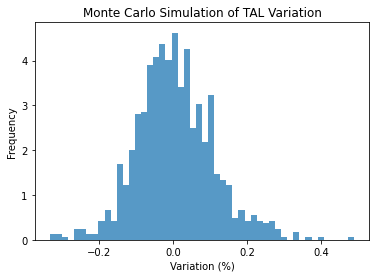

In [101]:
plt.hist(etf_returns, bins=50, density=True, alpha=0.75)
plt.xlabel('Variation (%)')
plt.ylabel('Frequency')
plt.title('Monte Carlo Simulation of TAL Variation')
plt.show()


In [102]:
etf_returns = etf_returns.dropna()

In [103]:
etf_returns = np.array(etf_returns)

# Confidence level for VaR and ES
confidence_level = 0.95

# Calculate the VaR
var = np.percentile(etf_returns, 100 * (1 - confidence_level))

# Calculate the ES
es = np.mean(etf_returns[etf_returns <= var])


In [104]:
currency_columns = ['USDCHF', 'USDEUR', 'USDGBP', 'USDJPY', 'USDCNY', 'USDSGD', 'USDGOLD']


In [105]:
print("TAL Statistical Summary")
print("-----------------------")
print("Mean Return:", etf_mean)
print("Standard Deviation:", etf_std)
print(f"{round(100 * (1 - confidence_level),4)}% Value at Risk (VaR):", var)
print(f"{round(100 * (1 - confidence_level),4)}% Expected Shortfall (ES):", es)


TAL Statistical Summary
-----------------------
Mean Return: 0.004874666683256017
Standard Deviation: 0.10388358403671497
5.0% Value at Risk (VaR): -0.14653169294558702
5.0% Expected Shortfall (ES): -0.20140458315484053


In [106]:
# Define the number of simulations
n_simulations = 1000

# Initialize lists to store the mean, standard deviation, VaR, and ES for each component
mean_returns = []
std_devs = []
vars = []
ess = []

# Confidence level for VaR and ES
confidence_level = 0.95

# Run the simulation for each component
for i in range(len(returns)):
    # Generate random samples from a normal distribution
    samples = np.random.normal(returns[i], vol[i], n_simulations)
    
    # Calculate the mean and standard deviation of the returns
    mean_returns.append(np.mean(samples))
    std_devs.append(np.std(samples))
    
    # Calculate the VaR
    vars.append(np.percentile(samples, 100 * (1 - confidence_level)))
    
    # Calculate the ES
    ess.append(np.mean(samples[samples <= vars[-1]]))


In [107]:
print("TAL Component Statistical Summary")
print("---------------------------------")
for i in range(len(returns)):
    print(f" {currency_columns[i]}:")
    print("Mean Return:", round(mean_returns[i],5))
    print("Standard Deviation:", round(std_devs[i],5))
    print(f"{round(100 * (1 - confidence_level),4)}% Value at Risk (VaR):", round(vars[i],5))
    print(f"{round(100 * (1 - confidence_level),4)}% Expected Shortfall (ES):", round(ess[i],5))
    print()


TAL Component Statistical Summary
---------------------------------
 USDCHF:
Mean Return: 0.00075
Standard Deviation: 0.04833
5.0% Value at Risk (VaR): -0.07655
5.0% Expected Shortfall (ES): -0.09982

 USDEUR:
Mean Return: 0.00201
Standard Deviation: 0.05617
5.0% Value at Risk (VaR): -0.10053
5.0% Expected Shortfall (ES): -0.11661

 USDGBP:
Mean Return: -0.00172
Standard Deviation: 0.07916
5.0% Value at Risk (VaR): -0.13487
5.0% Expected Shortfall (ES): -0.16384

 USDJPY:
Mean Return: -0.00237
Standard Deviation: 0.09447
5.0% Value at Risk (VaR): -0.15383
5.0% Expected Shortfall (ES): -0.19488

 USDCNY:
Mean Return: -0.00073
Standard Deviation: 0.09256
5.0% Value at Risk (VaR): -0.15428
5.0% Expected Shortfall (ES): -0.19424

 USDSGD:
Mean Return: -0.00348
Standard Deviation: 0.08941
5.0% Value at Risk (VaR): -0.15212
5.0% Expected Shortfall (ES): -0.18601

 USDGOLD:
Mean Return: 0.00043
Standard Deviation: 0.15404
5.0% Value at Risk (VaR): -0.25101
5.0% Expected Shortfall (ES): -0.329

In [108]:
# Combine the statistics into a DataFrame
statistics_df = pd.DataFrame({
    'Currency': currency_columns + ['TAL'],
    'Mean Return': mean_returns + [etf_mean],
    'Standard Deviation': std_devs + [etf_std],
    'VaR': vars + [var],
    'ES': ess + [es],
})


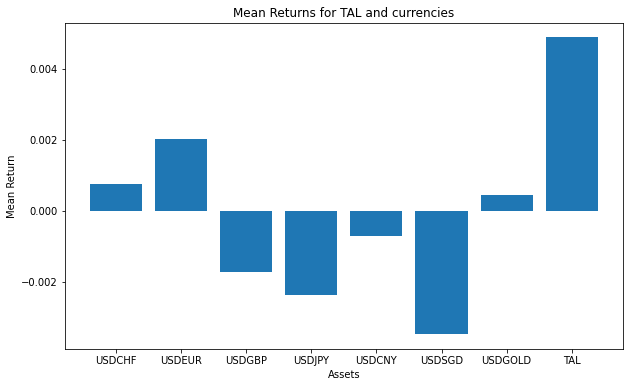

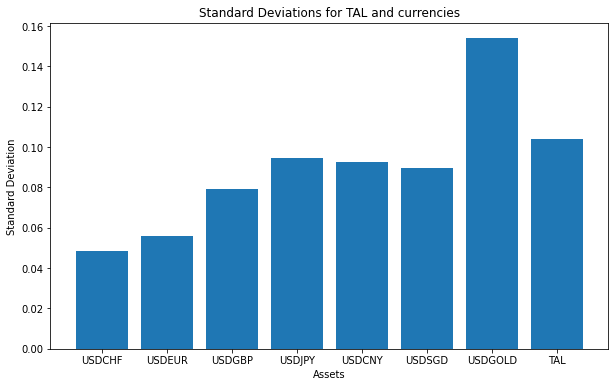

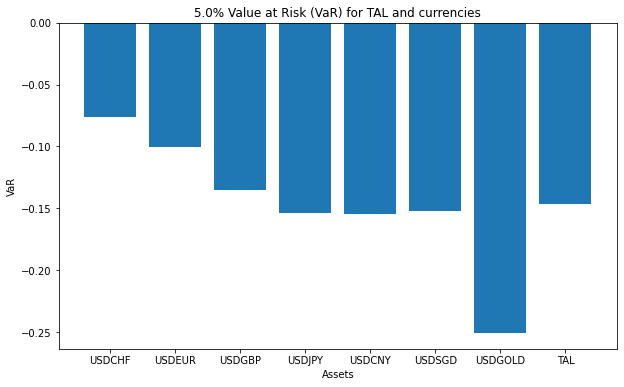

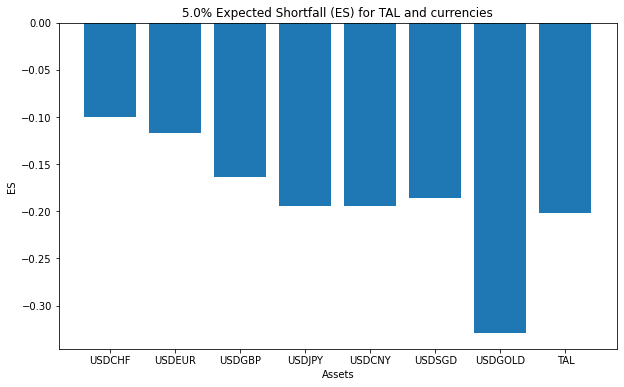

In [110]:
# Function to plot a bar chart for a given column
def plot_bar_chart(column, title, ylabel):
    plt.figure(figsize=(10, 6))
    ax = plt.bar(statistics_df['Currency'], statistics_df[column])
    plt.title(title)
    plt.xlabel('Assets')
    plt.ylabel(ylabel)
    plt.show()

# Plot the bar charts
plot_bar_chart('Mean Return', 'Mean Returns for TAL and currencies', 'Mean Return')
plot_bar_chart('Standard Deviation', 'Standard Deviations for TAL and currencies', 'Standard Deviation')
plot_bar_chart('VaR', f'{round(100 * (1 - confidence_level),4)}% Value at Risk (VaR) for TAL and currencies', 'VaR')
plot_bar_chart('ES', f'{round(100 * (1 - confidence_level),4)}% Expected Shortfall (ES) for TAL and currencies', 'ES')
